### 1. 병합

##### 작업 방향

1. 모든 테이블은 '기준년월', '발급회원번호'를 중복?식별자로 해서 merge가 가능합니다.
2. '회원정보' 테이블은 7월에 vip였던 사람들의 추이를 볼 수 있도록 구성되어있습니다.
3. 따라서 '회원정보' 테이블을 기준으로 join(merge)하면, 7월에 vip였던 사람들의 정보를 모두 통합할 수 있을 거라 생각됩니다.
4. 컬럼 순서도 중요하긴 하니까 저의 통합하는 순서는 01(회원정보)에 02(신용정보)를 붙이고, 그 다음 03.. 마지막엔 08 붙도록 하면 될 것 같습니다.

[ 테이블 넘버링 ]

01 - 회원정보

02 - 신용정보

03 - 승인매출정보

04 - 청구정보

05 - 잔액정보

06 - 채널정보

07 - 마케팅정보

08 - 성과 정보

##### raw data 처리:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 최초 버전 (메모리 이슈 발생 가능성이 있음)

# df01 = pd.read_csv('./통합데이터셋/2018_회원정보_통합.csv',encoding='utf-8')
# df02 = pd.read_csv('./통합데이터셋/2018_신용정보_통합.csv',encoding='utf-8')
# df03 = pd.read_csv('./통합데이터셋/2018_승인매출정보_통합.csv',encoding='utf-8')
# df04 = pd.read_csv('./통합데이터셋/2018_청구정보_통합.csv',encoding='utf-8')
# df05 = pd.read_csv('./통합데이터셋/2018_잔액정보_통합.csv',encoding='utf-8')
# df06 = pd.read_csv('./통합데이터셋/2018_채널정보_통합.csv',encoding='utf-8')
# df07 = pd.read_csv('./통합데이터셋/2018_마케팅정보_통합.csv',encoding='utf-8')
# df08 = pd.read_csv('./통합데이터셋/2018_성과정보_통합.csv',encoding='utf-8')

# merged_df = df01

# df_list = [df02, df03, df04, df05, df06, df07, df08]

# for df_el in df_list:
#     merged_df = pd.merge(merged_df, df_el, on=['기준년월', '발급회원번호'], how='left')

# merged_df.to_csv('./신용카드VIP회원정보.csv', encoding='utf-8')

In [3]:
# 메모리 과부하를 줄이는 방식

# import pandas as pd
# import gc

# df_final = pd.read_csv('./통합데이터셋/2018_회원정보_통합.csv', encoding='utf-8')

# paths = [
#     './통합데이터셋/2018_신용정보_통합.csv',
#     './통합데이터셋/2018_승인매출정보_통합.csv',
#     './통합데이터셋/2018_청구정보_통합.csv',
#     './통합데이터셋/2018_잔액정보_통합.csv',
#     './통합데이터셋/2018_채널정보_통합.csv',
#     './통합데이터셋/2018_마케팅정보_통합.csv',
#     './통합데이터셋/2018_성과정보_통합.csv'
# ]
# for path in paths:
#     df_el = pd.read_csv(path, encoding='utf-8')
    
#     df_final = pd.merge(df_final, df_el, on=['기준년월', '발급회원번호'], how='left')
    
#     del df_el

#     gc.collect()

# df_final.to_csv('./신용카드VIP회원정보2.csv', encoding='utf-8')

---

### 2. 만든 통합 파일(신용카드VIP회원정보.csv)의 전처리와 저장

In [4]:
# import numpy as np
# import pandas as pd

In [ ]:
df = pd.read_csv('../data/merged/신용카드VIP회원정보.csv', encoding = 'utf-8')

In [6]:
# 1. 제거할 컬럼 확인

# df.columns
    # '잔액_B0M_y', '연체일수_B2M_y', '월중평잔_y', '평잔_3M_y', '평잔_6M_y' 제거 후,
    # '잔액_B0M_x', '연체일수_B2M_x', '월중평잔_x', '평잔_3M_x', '평잔_6M_x' 의 각 컬럼명에서 _x를 제거
    # 'Unnamed: 0' 컬럼 제거

df.drop(columns=['잔액_B0M_y', '연체일수_B2M_y', '월중평잔_y', '평잔_3M_y', '평잔_6M_y'], inplace=True)

df.drop(columns=['Unnamed: 0'], inplace=True)

df.columns = df.columns.str.replace('_x', '')

df.columns

# 2. 나이 연령대 글자 제거하고 int 처리

df['연령'] = df['연령'].str.replace(r'\D', '', regex=True)

df['연령'] = df['연령'].astype(int)

# 3-1. Life_Stage의 이상치 제거 (= 연령대와 Life_Stage 정의가 매칭이 안 되는 경우)

# 20대와 30대 조건 : Life_Stage 값이 '5.자녀성장기(2)', '6.자녀출가기', '7.노령'에 해당하면 해당 열 제거
cond_2030 = df['연령'].isin([20, 30]) & df['Life_Stage'].isin(['5.자녀성장기(2)', '6.자녀출가기', '7.노령'])

# 40대 조건 : 40대는 Life_Stage 값이 '7.노령'에 해당하면 해당 열 제거
cond_40 = (df['연령'] == 40) & (df['Life_Stage'] == '7.노령')

# 50대, 60대, 70대 조건 : '1.Single', '2.가족형성기', '3.자녀출산기', '4.자녀성장기(1)'에 해당하면 해당 열 제거
cond_506070 = df['연령'].isin([50, 60, 70]) & df['Life_Stage'].isin(['1.Single', '2.가족형성기', '3.자녀출산기', '4.자녀성장기(1)'])

# 2. 모든 삭제 조건을 하나로 결합 (OR 조건)
drop_condition = cond_2030 | cond_40 | cond_506070

# 3. 조건에 해당하지 않는(~) 정상 데이터만 추출하여 덮어쓰기 (이상치 행 제거)
df = df[~drop_condition].copy()

# 3-1. (실행 안 해도 전처리에 이상 없음) 제대로 삭제되었는지 확인

base = df[["발급회원번호", "연령", "Life_Stage"]].drop_duplicates()
base

cnt = base.groupby(["연령", "Life_Stage"]).size().reset_index(name="건수")
cnt

total = cnt.groupby(["연령"])["건수"].sum().reset_index(name="전체건수")
total

result = cnt.merge(total, on="연령", how="left")
result

# 3-1. (계속) 6개월 동안의 데이터 중 하나의 컬럼이라도 빈 회원은 데이터 삭제

    # 1. 발급회원번호별 데이터 개수 집계
user_counts = df['발급회원번호'].value_counts()
print(user_counts)

    # 2. 데이터가 정확히 6개인 발급회원번호만 추출
valid_users = user_counts[user_counts == 6].index

    # 3. 해당 회원번호에 속하는 데이터만 남기기
df = df[df['발급회원번호'].isin(valid_users)].copy()

# 3-2. Life_Stage 컬럼을 활용한 파생변수- '양육자녀_유무' 생성

transform = {
    '1.Single': 0, 
    '2.가족형성기': 0, 
    '3.자녀출산기': 1, 
    '4.자녀성장기(1)': 1, 
    '5.자녀성장기(2)': 1, 
    '6.자녀출가기': 0, 
    '7.노령': 0
}

# map 함수를 적용하여 새로운 컬럼 생성
df['양육자녀_유무'] = df['Life_Stage'].map(transform)

df[['기준년월','발급회원번호', 'Life_Stage','양육자녀_유무']].head(10)

# 4. 이상치, 자료형 변경

# 4-1. '연체일수_B2M_x' -99999999

print(len(df[df['연체일수_B2M'] > 0])) # 21,426
print(len(df[df['연체일수_B2M'] < 0])) # 3,064,586
print(len(df[df['연체일수_B2M'] == 0])) # 499,540

df.loc[df['연체일수_B2M'] < 0, '연체일수_B2M'] = -1

print(len(df[df['연체일수_B2M'] < -1])) #0

# # 4-2. '기준년월'

# df['기준년월'] = df['기준년월'].astype(str) 
# print(type(df['기준년월'].iloc[0]))
# print(df['기준년월'])

# df['기준년월'] = pd.to_datetime(df['기준년월'].astype(str).str[:6], format='%Y%m')

# print(df['기준년월'].dtype) 

# # 옵션: 추가 날짜 (월, 년, 월년) 컬럼 만들기
# # df['year'] = df['기준년월'].dt.year
# # df['month'] = df['기준년월'].dt.month
# # df['year_month'] = df['기준년월'].dt.to_period('M')

# print(df['기준년월'])

발급회원번호
SYN_0          6
SYN_1999369    6
SYN_1999459    6
SYN_1999463    6
SYN_1999464    6
              ..
SYN_2369781    1
SYN_2570546    1
SYN_2685302    1
SYN_1331585    1
SYN_2421235    1
Name: count, Length: 597408, dtype: int64
21208
3060527
498183
0


In [7]:
# 1인 값은 이탈자
df["y"] = (df["이용금액_신용_R12M"] == 0).astype(int)
df

# df.drop("Unnamed: 0", axis = 1)

df.to_csv("./신용카드VIP회원정보_최종.csv", index = False, encoding="UTF-8")

# print(len(df['y']==0))
# print(len(df[df['y']==0]))
# print(len(df[df['y']==1]))

In [8]:
X = df.drop(columns=["이용금액_신용_R12M", "y"])  # drop both
y = df["y"]

# Model: LightGBM
- data split: group shuffle split + time-based split (기간 기반)

In [9]:
# korean font setting
import platform

if platform.system() == 'Darwin': # macOS
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')

plt.rcParams['axes.unicode_minus'] = False

In [10]:
len(df.columns)
len(X)

3579918

In [11]:
groups = df['발급회원번호']  

df['기준년월_dt'] = pd.to_datetime(
    df['기준년월'].astype(str), format='%Y%m'
)
cutoff = df['기준년월_dt'].quantile(0.8)
print(f"\n Time-based split  —  cutoff: {cutoff.strftime('%Y-%m')}")

train_mask = df['기준년월_dt'] <= cutoff
test_mask  = df['기준년월_dt'] >  cutoff

X_train_time = X[train_mask]
X_test_time  = X[test_mask]
y_train_time = y[train_mask]
y_test_time  = y[test_mask]

print(f"  Train: {len(X_train_time)} rows  |  "
      f"Users: {groups[train_mask].nunique()}")
print(f"  Test : {len(X_test_time)} rows   |  "
      f"Users: {groups[test_mask].nunique()}")
print(f"  Train 이탈률: {y_train_time.mean():.2%}")
print(f"  Test 이탈률: {y_test_time.mean():.2%}")


[A] Time-based split  —  cutoff: 2018-11
  Train: 2983265 rows  |  Users: 596653
  Test : 596653 rows   |  Users: 596653
  Train churn rate: 0.75%
  Test  churn rate: 1.11%


✓ All dtypes are numeric — safe to fit
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Number of positive: 22503, number of negative: 2960762
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8486
[LightGBM] [Info] Number of data points in the train set: 2983265, number of used features: 59
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 roun

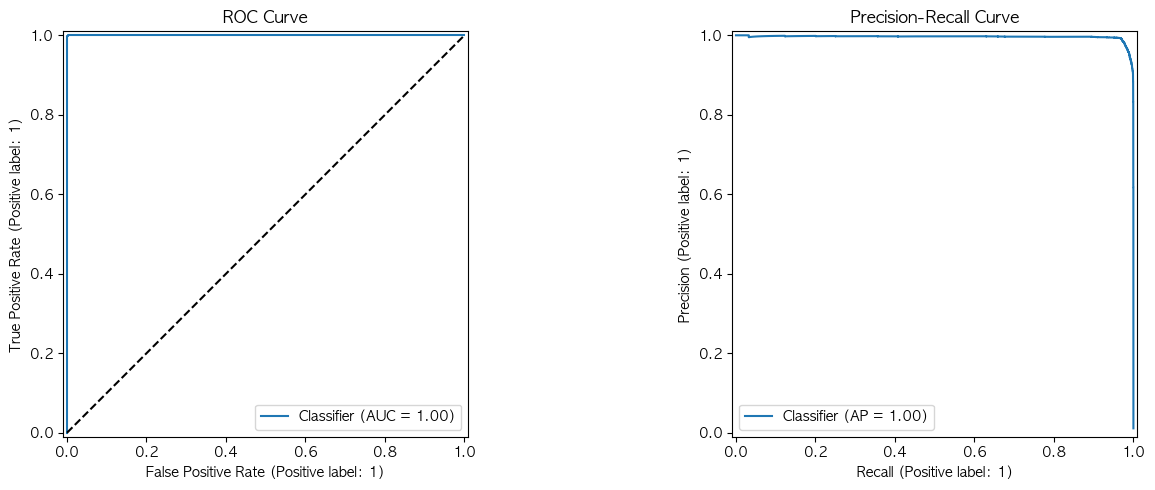

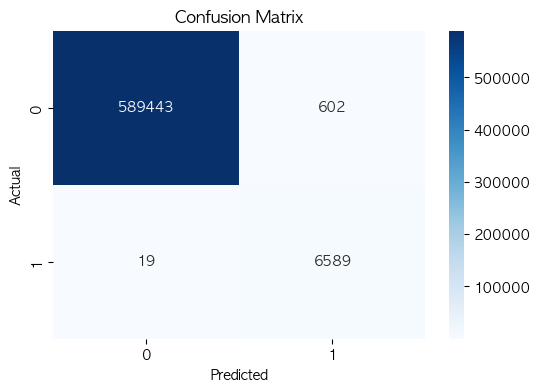

In [12]:
from sklearn.preprocessing import OrdinalEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    RocCurveDisplay, 
    PrecisionRecallDisplay
)

# OrdinalEncoder 
cat_cols = ['거주시도명', 'Life_Stage', '이용금액대']
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = enc.fit_transform(X[cat_cols].astype(str))
X = X.drop(columns=['발급회원번호'], errors='ignore')  # ID always dropped

# 업데이트된  X 데이터로 time split
train_mask = df['기준년월_dt'] <= cutoff
test_mask  = df['기준년월_dt'] >  cutoff

X_train_time = X[train_mask]
X_test_time  = X[test_mask]
y_train_time = y[train_mask]
y_test_time  = y[test_mask]

# X data 확인
# bad_cols = X_train_time.select_dtypes(exclude=['int', 'float', 'bool']).columns.tolist()
# if bad_cols:
#     print(f"X data columns data type problem")
# else:
#     print("X data columns good")


model = LGBMClassifier(
    num_leaves=31,
    max_depth=5,
    min_child_samples=50,
    reg_alpha=0.1, #L1 규제
    reg_lambda=1.0, #L2 규제
    subsample=0.7,
    subsample_freq=1,
    colsample_bytree=0.7,
    n_estimators=1000, #생성할 트리의 최대 개수
    learning_rate=0.02,
    class_weight='balanced', #이탈과, 이탈아는 비율 맞춥기 (데이터 불균형때 쓰임) 데이터 불균형이 심할 때
    early_stopping_rounds=50,
    random_state=42,
    n_jobs=-1 #CPU 모든 사용
)

model.fit(
    X_train_time, y_train_time,
    eval_set=[(X_test_time, y_test_time)],
)




# 이중 예측 0 | 1
y_pred = model.predict(X_test_time)

# 이탈 확률
y_prob = model.predict_proba(X_test_time)[:, 1]
print(" \n \n 분류 결과: \n \n ")

# recall, f1
print(classification_report(y_test_time, y_pred))

# AUC
auc_score = roc_auc_score(y_test_time, y_prob)
print(f"ROC-AUC Score: {auc_score:.4f}")

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
RocCurveDisplay.from_predictions(y_test_time, y_prob, ax=ax[0])
ax[0].set_title("ROC Curve")
ax[0].plot([0, 1], [0, 1], 'k--') # random chance line

# Precision-Recall Curve 
PrecisionRecallDisplay.from_predictions(y_test_time, y_prob, ax=ax[1])
ax[1].set_title("Precision-Recall Curve")

plt.tight_layout()
plt.show()

import seaborn as sns

cm = confusion_matrix(y_test_time, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Linear models require scaling!
lr_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='elasticnet', 
        solver='saga', 
        l1_ratio=0.5,         # Mix of L1 (feature selection) and L2 (stability)
        C=0.1,                # Lower C = Stronger Regularization
        class_weight='balanced',
        random_state=42
    ))
])

lr_model.fit(X_train_time, y_train_time)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'elasticnet'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",0.1
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work